# NSGA2 Generator
This notebook demonstrates the use of the generator `NSGA2Generator` which implements the NSGA-II algorithm from [1]. We show how to set up the optimizer object, use it to solve a test problem, and show off some of the generator's output features. Running this notebook will generate files in a temporary directory on your computer. These files will be cleaned up at the end.

In [1]:
import json
import logging
import matplotlib.pyplot as plt
import os
import pandas as pd
import shutil
import tempfile

from xopt.generators.ga.nsga2 import NSGA2Generator, PolynomialMutation, SimulatedBinaryCrossover
from xopt.resources.test_functions.zdt import construct_zdt
from xopt import Xopt, Evaluator, VOCS

In [2]:
# The NSGA2Generator object emits logger messages
# Configure the logging module to output them to console
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',  # Format for log messages
    datefmt='%Y-%m-%d %H:%M:%S'  # Date/time format
)

In [3]:
# Get the problem ZDT2 and create an Xopt evaluator
prob_vocs, prob_fun, _ = construct_zdt(30, 3)
ev = Evaluator(function=prob_fun)

### Generator Setup and Use
First we create the `NSGA2Generator` object, demonstrate some of its settings, and then use it to solve the ZDT3 test problem.

In [4]:
# Create the NSGA2 generator with default settings
generator = NSGA2Generator(
    vocs=prob_vocs,  # Must provide the problem's details
)

# Let's demonstrate controlling the generator's hyperparameters and settings
generator = NSGA2Generator(
    vocs=prob_vocs,  # Must provide the problem's details
    population_size=50,  # How many individuals in a population
    mutation_operator=PolynomialMutation(pm=1/30, eta_m=20),  # Can manually specify mutation operator and hyperparameters
    crossover_operator=SimulatedBinaryCrossover(delta_1=0.5, delta_2=0.5, eta_c=20),  # Similarly can specify crossover manually
    deduplicate_output=True,  # Performs deduplication of candidate individuals. Ensure unique outputs from generator.
)

2025-03-02 23:23:49 - xopt.generator - INFO - Initialized generator nsga2
2025-03-02 23:23:49 - xopt.generator - INFO - Initialized generator nsga2


In [5]:
# Run the optimizer for a few generations. Notice log output printed below this cell
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)

for _ in range(3):
    X.step()

2025-03-02 23:23:49 - xopt.base - INFO - Running Xopt step
2025-03-02 23:23:49 - xopt.generators.deduplicated - INFO - generated 50 candidates in 2.64ms (removed 0 duplicate individuals)
2025-03-02 23:23:50 - xopt.generators.ga.nsga2 - INFO - adding 50 new evaluated individuals to generator
2025-03-02 23:23:50 - xopt.generators.ga.nsga2 - INFO - completed generation 1 in 0.021s (n_feasible=0, n_err=0, children_performance=0.000s (0.000s), add_data_round=0, fevals=50, n_candidates=50)
2025-03-02 23:23:50 - xopt.base - INFO - Running Xopt step
2025-03-02 23:23:50 - xopt.generators.deduplicated - INFO - generated 50 candidates in 11.06ms (removed 0 duplicate individuals)
2025-03-02 23:23:50 - xopt.generators.ga.nsga2 - INFO - adding 50 new evaluated individuals to generator
2025-03-02 23:23:50 - xopt.generators.ga.nsga2 - INFO - completed generation 2 in 0.022s (n_feasible=0, n_err=0, children_performance=0.000s (0.000s), add_data_round=0, fevals=100, n_candidates=100)
2025-03-02 23:23:50

### Exploring Optimizer Output
We now take a look at the metadata associated with the optimizer run as well as its output.

In [6]:
%%time
# Run for longer with log output turned off
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

for _ in range(47):
    X.step()

CPU times: total: 859 ms
Wall time: 945 ms


In [7]:
# Inspect generator properties
print(f"Saw {generator.fevals} function evaluations")  # Number of function evaluations returned to generator
print(f"Completed {generator.n_generations} generations")  # Number of generations finished
print(f"Generated {generator.n_candidates} candidate solutions")  # Number of individuals generated

Saw 2500 function evaluations
Completed 50 generations
Generated 2500 candidate solutions


In [8]:
# All evaluations are stored in the following Dataframe. Speific to this generator, a `xopt_parent_generation` and 
# `xopt_candidate_idx` columns which indicate from which generation the indvidual's parents belong to as well as providing a 
# unique index for indviduals.
# 
# NOTE: The data DataFrame is not stored when serializing the generator. It must be saved on its own for later use.
generator.data.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.029961,0.699532,0.793239,0.426525,0.408941,0.791914,0.193299,0.445699,0.218711,0.372088,...,0.570526,0.420237,0.949011,0,25,0.029961,5.221769,5.657707,0.000055,False
1,0.030504,0.045139,0.518436,0.481968,0.770776,0.289677,0.466708,0.252085,0.612965,0.856142,...,0.193029,0.414187,0.620067,0,27,0.030504,4.430133,4.839306,0.000013,False
2,0.041117,0.767541,0.999218,0.950000,0.202371,0.955482,0.245319,0.925141,0.467296,0.750499,...,0.932530,0.235312,0.607547,0,29,0.041117,5.756354,6.305041,0.000009,False
3,0.064599,0.003448,0.589958,0.031328,0.459890,0.893194,0.060856,0.563615,0.197425,0.864629,...,0.426190,0.522685,0.246234,0,46,0.064599,4.370750,4.996819,0.000009,False
4,0.096606,0.136052,0.174209,0.274200,0.830271,0.354479,0.346574,0.960729,0.642327,0.952452,...,0.092799,0.642389,0.860824,0,34,0.096606,4.525206,5.247482,0.000009,False


In [9]:
# Each population the optimizer has seen is stored by the unique indices of each individual.
print(generator.history_idx[-1][:16])  # Show the first few indices of last generation

# If you have the data DataFrame you can extract all variables, objectives, constraints for each population
# Get a DataFrame of all information for the first population with every row being an individual
generator.data[generator.data["xopt_candidate_idx"].isin(generator.history_idx[0])].head()

[2454, 2380, 2469, 2452, 2491, 2344, 2460, 2431, 2494, 2377, 2461, 2465, 2472, 2453, 2430, 2456]


,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.029961,0.699532,0.793239,0.426525,0.408941,0.791914,0.193299,0.445699,0.218711,0.372088,...,0.570526,0.420237,0.949011,0,25,0.029961,5.221769,5.657707,0.000055,False
1,0.030504,0.045139,0.518436,0.481968,0.770776,0.289677,0.466708,0.252085,0.612965,0.856142,...,0.193029,0.414187,0.620067,0,27,0.030504,4.430133,4.839306,0.000013,False
2,0.041117,0.767541,0.999218,0.950000,0.202371,0.955482,0.245319,0.925141,0.467296,0.750499,...,0.932530,0.235312,0.607547,0,29,0.041117,5.756354,6.305041,0.000009,False
3,0.064599,0.003448,0.589958,0.031328,0.459890,0.893194,0.060856,0.563615,0.197425,0.864629,...,0.426190,0.522685,0.246234,0,46,0.064599,4.370750,4.996819,0.000009,False
4,0.096606,0.136052,0.174209,0.274200,0.830271,0.354479,0.346574,0.960729,0.642327,0.952452,...,0.092799,0.642389,0.860824,0,34,0.096606,4.525206,5.247482,0.000009,False


Text(0.5, 1.0, 'ZDT3, Generation 50')

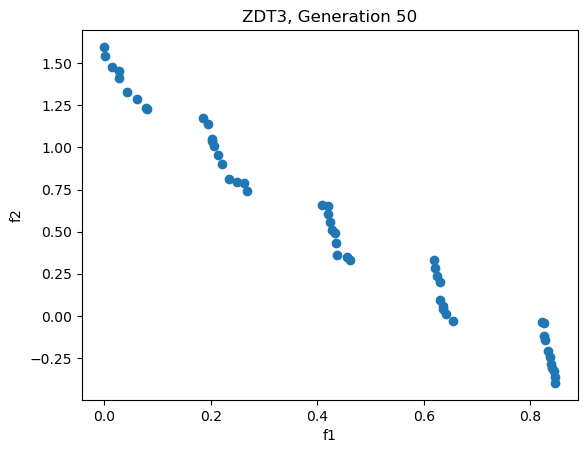

In [10]:
# Using the population records we can plot the final generation's objective functions
final_pop = generator.data[generator.data["xopt_candidate_idx"].isin(generator.history_idx[-1])]
plt.scatter(final_pop["f1"], final_pop["f2"])
plt.xlabel("f1")
plt.ylabel("f2")
plt.title(f"ZDT3, Generation {generator.n_generations}")

# File Output from Generator
In this section, we will take a look at the files which can be automatically written by the optimizer. We will create a temporary directory and clean it up at the end of this notebook.

The output files are the following.
 - `data.csv`: All data evaluated during the optimization
 - `vocs.txt`: The VOCS object so that the objectives, constraints, decision variables are retained alongside the data
 - `populations.csv`: Each population is written here with a column `xopt_generation` to distinguish which generation the row belongs to
 - `checkpoints`: This generator periodically saves its full state to timestamped files in this directory

In [11]:
# Setup our output directory
output_dir = tempfile.mkdtemp()
print(f"Will write data to \"{output_dir}\"")

Will write data to "C:\Users\chris\AppData\Local\Temp\tmpej0ljh3t"


In [12]:
# Set up a generator configured to output data
generator = NSGA2Generator(
    vocs=prob_vocs,
    output_dir=output_dir,  # Where will we write data
    checkpoint_freq=8,  # How often (in terms of generations) should we save the optimizer state?
)

# Run it for a couple of generations
ev.max_workers = generator.population_size
X = Xopt(generator=generator, evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()

In [13]:
# Check out the generated files
print(f"\"{output_dir}\": {os.listdir(output_dir)}")
checkpoint_dir = os.path.join(output_dir, "checkpoints")
print(f"\"checkpoints\": {os.listdir(checkpoint_dir)}")

"C:\Users\chris\AppData\Local\Temp\tmpej0ljh3t": ['checkpoints', 'data.csv', 'populations.csv', 'vocs.txt']
"checkpoints": ['20250302_232351_1.txt', '20250302_232351_2.txt', '20250302_232352_1.txt', '20250302_232352_2.txt']


In [14]:
# In the event data was already written to `output_dir` the generator will choose a new path with a numeric suffix
# to avoid overwriting anything.
X = Xopt(generator=NSGA2Generator(vocs=prob_vocs, output_dir=output_dir), evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()

# Compare the requested path and where the data ended up
print(f"Requested path: \"{output_dir}\"")
print(f"Path used:      \"{X.generator.output_dir}\"")

# Clean up the directory
shutil.rmtree(X.generator.output_dir)

Requested path: "C:\Users\chris\AppData\Local\Temp\tmpej0ljh3t"
Path used:      "C:\Users\chris\AppData\Local\Temp\tmpej0ljh3t_2"


In [15]:
# Load all data back in
df = pd.read_csv(os.path.join(generator.output_dir, "data.csv"))
df.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x7,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error
0,0.026255,0.043812,0.207591,0.390275,0.001161,0.468705,0.104168,0.287362,0.907579,0.360770,...,0.240535,0.543106,0.748566,0,1,0.026255,4.100019,4.461555,0.000034,False
1,0.030294,0.458170,0.287887,0.161541,0.254714,0.599771,0.524809,0.680542,0.560945,0.631960,...,0.557438,0.197054,0.058142,0,12,0.030294,4.945382,5.373518,0.000011,False
2,0.056193,0.718432,0.177326,0.995120,0.689862,0.496913,0.171198,0.321178,0.327106,0.249042,...,0.728176,0.094822,0.689543,0,48,0.056193,4.849971,5.458956,0.000009,False
3,0.070448,0.647294,0.520056,0.811145,0.118270,0.041115,0.415966,0.841668,0.536006,0.668331,...,0.552670,0.667864,0.613480,0,4,0.070448,5.085262,5.779769,0.000009,False
4,0.116732,0.817935,0.554644,0.420691,0.214479,0.711840,0.387302,0.714087,0.859221,0.812720,...,0.428068,0.549381,0.643911,0,44,0.116732,5.423571,6.216883,0.000008,False


In [16]:
# Read the VOCS object back in. This can be used for data analysis / restarting optimizations
with open(os.path.join(generator.output_dir, "vocs.txt")) as f:
    vocs_from_file = VOCS.from_dict(json.load(f))

# Show the objectives
vocs_from_file.objectives

{'f1': 'MINIMIZE', 'f2': 'MINIMIZE'}

In [17]:
# Load the populations and get just the last population
df = pd.read_csv(os.path.join(generator.output_dir, "populations.csv"))
last_pop = df[df["xopt_generation"] == df["xopt_generation"].max()]
last_pop.head()

,x1,x10,x11,x12,x13,x14,x15,x16,x17,x18,...,x8,x9,xopt_parent_generation,xopt_candidate_idx,f1,f2,g,xopt_runtime,xopt_error,xopt_generation
1550,8.536163e-01,0.004111,0.100098,0.388729,0.016604,0.238399,0.011345,0.059577,0.018677,0.007590,...,0.183342,0.027384,30,1505,8.536163e-01,-0.219973,1.902507,0.000008,False,32
1551,6.889567e-07,0.044196,0.100205,0.387604,0.011373,0.182221,0.010081,0.049772,0.080951,0.059935,...,0.130740,0.027530,28,1412,6.889567e-07,1.943873,1.945031,0.000038,False,32
1552,1.922893e-01,0.013426,0.106653,0.339334,0.034372,0.237704,0.022071,0.073676,0.019639,0.000796,...,0.183394,0.027797,30,1511,1.922893e-01,1.419966,1.992880,0.000008,False,32
1553,6.152850e-01,0.003987,0.119558,0.406334,0.014527,0.238582,0.014265,0.059136,0.018499,0.001657,...,0.185312,0.027366,29,1452,6.152850e-01,0.537049,1.903497,0.000008,False,32
1554,4.413207e-01,0.047329,0.101080,0.468379,0.016707,0.219617,0.029245,0.048719,0.099208,0.057597,...,0.184231,0.027391,31,1564,4.413207e-01,0.606279,1.961760,0.000008,False,32


In [18]:
# Reload the optimizer from its last checkpoint
# NOTE: the vocs object is not retained with the checkpoint and should be added as in the following code
last_checkpoint = os.path.join(checkpoint_dir, os.listdir(checkpoint_dir)[-1])
with open(last_checkpoint) as f:
    restored_generator = NSGA2Generator.from_dict({"vocs": prob_vocs, **json.load(f)})
print(f"From file: {restored_generator}")

# Demonstrate using the generator after loading (starting optimization from its last saved point)
X = Xopt(generator=restored_generator, evaluator=ev, vocs=prob_vocs)
for _ in range(32):
    X.step()
print(f"Further optimization: {restored_generator}")

# Clean up the output
shutil.rmtree(X.generator.output_dir)

From file: NSGA2Generator(pop_size=50, crossover=SimulatedBinaryCrossover, mutation=PolynomialMutation, deduplicated=True, completed_gens=32, fevals=1600)
Further optimization: NSGA2Generator(pop_size=50, crossover=SimulatedBinaryCrossover, mutation=PolynomialMutation, deduplicated=True, completed_gens=64, fevals=3200)


In [19]:
# Clean up the original output
shutil.rmtree(output_dir)